In [1]:
import pandas as pd
import numpy as np
import pickle

import os
from PIL import Image

import torch
import torch.nn as nn
from torchvision.io import read_image, ImageReadMode
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision

from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

from tqdm.notebook import trange, tqdm

import random

from transformers import BertTokenizer, AutoTokenizer, AutoModel, BertModel

import matplotlib.pyplot as plt

In [2]:
# with open('../csv/word2idx.pickle', 'rb') as file:
#     word2idx = pickle.load(file)
    
# word2idx['<pad>']=len(word2idx)
# word2idx['<unk>']=len(word2idx)
# len(word2idx)

# idx2word = {v:k for k, v in word2idx.items()}
# len(idx2word)

In [43]:
df = pd.read_pickle('../csv/generating_training_df.pickle')
df.columns

Index(['patch_paths_x', 'pid', 'cluster_assignment', 'complete_tokens',
       'dtype', 'notes'],
      dtype='object')

In [44]:
df.columns = ['patch_paths', 'pid', 'cluster_assignment', 'complete_tokens','dtype', 'notes']
df.head()

,patch_paths,pid,cluster_assignment,complete_tokens,dtype,notes
0,/project/GutIntelligenceLab/ss4yd/gtex_data/pr...,GTEX-R55E-1726,4,"[2, pieces, 5x7, mm, broken, apart, good, morp...",train,2 pieces ~9.5x7 mm; 1 broken apart; good morph...
1,/project/GutIntelligenceLab/ss4yd/gtex_data/pr...,GTEX-R55E-1726,4,"[2, pieces, 5x7, mm, broken, apart, good, morp...",train,2 pieces ~9.5x7 mm; 1 broken apart; good morph...
2,/project/GutIntelligenceLab/ss4yd/gtex_data/pr...,GTEX-R55E-1726,4,"[2, pieces, 5x7, mm, broken, apart, good, morp...",train,2 pieces ~9.5x7 mm; 1 broken apart; good morph...
3,/project/GutIntelligenceLab/ss4yd/gtex_data/pr...,GTEX-R55E-1726,4,"[2, pieces, 5x7, mm, broken, apart, good, morp...",train,2 pieces ~9.5x7 mm; 1 broken apart; good morph...
4,/project/GutIntelligenceLab/ss4yd/gtex_data/pr...,GTEX-R55E-1726,4,"[2, pieces, 5x7, mm, broken, apart, good, morp...",train,2 pieces ~9.5x7 mm; 1 broken apart; good morph...


In [5]:
# df=df.set_index(['pid','cluster_assignment'])
# df

In [45]:
pid_batch_size=8
img_per_pid=8
num_cluster=8

In [46]:
unique_pids=pd.unique(df.pid)
batches = [list(unique_pids[i:i+pid_batch_size]) for i in pid_batch_size*np.arange(0, len(unique_pids)//pid_batch_size+1, 1)]
len(batches)

49

In [47]:
batches = [x + list(np.random.choice(df.pid.unique(), pid_batch_size-len(x))) \
           if (len(x)<pid_batch_size) else x for x in batches ]

In [48]:
len(list(batches[-1])+list(np.random.choice(df.pid.unique(), pid_batch_size-len(batches[-1]))))

8

In [49]:
len(batches[-1])

8

In [50]:
class WSIBatchedDataset_old(Dataset):
    
    def __init__(self, df, dtype, word2idx, shuffle=True, pid_batch_size=8, img_per_pid=8, \
                 num_cluster=8, img_transform=None, text_transform=None):
        self.df = df
        self.dtype = dtype
        self.word2idx = word2idx
        self.img_transform = img_transform
        self.text_transform = text_transform
        self.typ_df = df[df['dtype']==dtype]
        self.shuffle = shuffle
        
        self.unique_pids = list(self.typ_df.pid.unique())
        
        if self.shuffle:
            random.shuffle(self.unique_pids)
        
        self.pid_batches = [self.unique_pids[i:i+pid_batch_size] for i in \
                            pid_batch_size*np.arange(0, len(unique_pids)//pid_batch_size+1, 1)]
        
        self.tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
        
    def __len__(self):
        return len(self.pid_batches)
    
    def __getitem__(self, idx):
        
        pids = self.pid_batches[idx]
        
        img_list, text_list = self.return_batch_img_list(self.typ_df, pids, num_cluster=8)
        img_tensor, text_tensor = self.create_batch_tensors(img_list, text_list)
        
        
        return img_tensor, text_tensor
    
    def create_unique_pid_batches(pids, pid_batch_size=8):
        
        pid_batches = [list(pids[i:i+pid_batch_size]) for i in \
                            pid_batch_size*np.arange(0, len(pids)//pid_batch_size+1, 1)]
        
        pid_batches = [x + list(np.random.choice(pids, pid_batch_size-len(x))) \
           if (len(x)<pid_batch_size) else x for x in pid_batches ]
        
        return pid_batches
        
    
    def create_batch_tensors(self, img_list, text_list, img_transform=None, text_transform=None):
        
        img_tensor_list = []
        for img_path in img_list:
            image = read_image(img_path, mode=ImageReadMode.RGB)
            if self.img_transform:
                image = self.img_transform(image)
            image = image.unsqueeze(0)
            img_tensor_list.append(image)
            
        
        img_tensor = torch.cat(img_tensor_list)
        text_tensor = self.create_caption_tensors(text_list, word2idx, text_transform=text_transform)
        
        return img_tensor, text_tensor
    
    def create_caption_tensors(self, text_list, word2idx, token_size=50, text_transform=None):
        
        text_tensor_list = []
        for tokens in text_list:
            idx_tokens = [word2idx[i] for i in tokens] + [word2idx['<pad>'] for j in range(token_size-len(tokens))]
            idx_tokens = torch.LongTensor(idx_tokens).reshape(1,-1)
            text_tensor_list.append(idx_tokens)
        
        return torch.cat(text_tensor_list)
        
    def return_batch_img_list(self, df, pids, num_cluster=8):
        img_list=[]
        text_list=[]
        for pid in pids:
            tdf = df[df['pid']==pid]
            if len(tdf) < num_cluster:
                img_list+=list(tdf['patch_paths'])
                text_list+=list(tdf['complete_tokens'])
            elif len(tdf['cluster_assignment'].unique())==num_cluster:
                for c in range(num_cluster):
                    img_list+=list(tdf[tdf['cluster_assignment']==c]['patch_paths'].sample(1))
                    text_list+=[list(tdf['complete_tokens'])[0]]
                        
            else:
                img_list+=list(tdf['patch_paths'].sample(num_cluster))
            
                text_list+=[list(tdf['complete_tokens'])[0] for i in range(num_cluster)]
            
        
        return img_list, text_list

In [51]:
class WSIBatchedDataset(Dataset):
    
    def __init__(self, df, dtype, tokenizer, shuffle=True, pid_batch_size=8, img_per_pid=8, \
                 num_cluster=8, img_transform=None, text_transform=None):
        self.df = df
        self.dtype = dtype
        self.img_transform = img_transform
        self.text_transform = text_transform
        self.typ_df = df[df['dtype']==dtype]
        self.shuffle = shuffle
        self.pid_batch_size = pid_batch_size
        
        self.unique_pids = list(self.typ_df.pid.unique())
        
        if self.shuffle:
            random.shuffle(self.unique_pids)
        
        self.pid_batches = self.create_unique_pid_batches(self.unique_pids, self.pid_batch_size)
        
        self.tokenizer = tokenizer
        
    def __len__(self):
        return len(self.pid_batches)
    
    def __getitem__(self, idx):
        
        pids = self.pid_batches[idx]
        
        img_list, text_list, img_seps, pids = self.return_batch_img_list(self.typ_df, pids, num_cluster=8)
        img_tensor, text_tensor, attention_tensor, token_types = self.create_batch_tensors(img_list, text_list)
        
        
        return img_tensor, text_tensor,attention_tensor, token_types, img_seps, img_list
    
    def create_unique_pid_batches(self, pids, pid_batch_size=8):
        
        pid_batches = [list(pids[i:i+pid_batch_size]) for i in \
                            pid_batch_size*np.arange(0, len(pids)//pid_batch_size+1, 1)]
        
        pid_batches = [x + list(np.random.choice(pids, pid_batch_size-len(x))) \
           if (len(x)<pid_batch_size) else x for x in pid_batches ]
        
        return pid_batches
    
    def create_batch_tensors(self, img_list, text_list, img_transform=None, text_transform=None):
        
        img_tensor_list = []
        for img_path in img_list:
            image = read_image(img_path, mode=ImageReadMode.RGB)
            if self.img_transform:
                image = self.img_transform(image)
            image = image.unsqueeze(0)
            img_tensor_list.append(image)
            
        
        img_tensor = torch.cat(img_tensor_list)
        text_tensor, attention_tensor, token_types = self.create_caption_tensors(text_list, text_transform=text_transform)
        
        return img_tensor, text_tensor, attention_tensor, token_types
    
    def create_caption_tensors(self, text_list, max_length=80, text_transform=None):
        
        text_tensor_list = []
        attention_masks = []
        token_types = []
        for sent in text_list:
            encoded_dict = self.tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = max_length,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                        truncation=True,   # remove warnings from printing
                   )
            text_tensor_list.append(encoded_dict['input_ids'])
            attention_masks.append(encoded_dict['attention_mask'])
            token_types.append(encoded_dict['token_type_ids'])
            
        
        return torch.cat(text_tensor_list, dim=0), torch.cat(attention_masks, dim=0), torch.cat(token_types, dim=0)
        
    def return_batch_img_list(self, df, pids, num_cluster=8):
        img_list=[]
        text_list=[]
        img_seps=[]
        for pid in pids:
            tdf = df[df['pid']==pid]
            if len(tdf) < num_cluster:
                img_per_cluster = num_cluster//len(tdf['cluster_assignment'].unique())
#                 print(img_per_cluster)
                for c in tdf['cluster_assignment'].unique():
                    img_list+=list(tdf[tdf['cluster_assignment']==c]['patch_paths'].sample(img_per_cluster, replace=True))
                    text_list+=list(tdf[tdf['cluster_assignment']==c]['notes'].sample(img_per_cluster, replace=True))
                extra_imgs = num_cluster-img_per_cluster*len(tdf['cluster_assignment'].unique())
                if (extra_imgs>0):
                    img_list+=list(tdf['patch_paths'].sample(extra_imgs))
                    text_list+=list(tdf['notes'].sample(extra_imgs))
            elif len(tdf['cluster_assignment'].unique())==num_cluster:
                for c in range(num_cluster):
                    img_list+=list(tdf[tdf['cluster_assignment']==c]['patch_paths'].sample(1))
                    text_list+=list(tdf[tdf['cluster_assignment']==c]['notes'].sample(1))
                        
            else:
                img_list+=list(tdf['patch_paths'].sample(num_cluster))
                text_list+=list(tdf['notes'].sample(num_cluster))
            img_seps.append(len(img_list))
            
        
        return img_list, text_list, img_seps, pids

In [52]:
%%time

normalize = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

transform=transforms.Compose([
    transforms.Resize([224,224]),
    transforms.ConvertImageDtype(torch.float),
    normalize,
        ])

tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
wsi_batch_dataset = WSIBatchedDataset(df, dtype='train', tokenizer=tokenizer, img_transform=transform)
train_loader = torch.utils.data.DataLoader(wsi_batch_dataset,batch_size=1, shuffle=True, num_workers=1, pin_memory=True)

img_tensor, text_tensor, attention_tensor, token_types, img_seps, pids = wsi_batch_dataset.__getitem__(1)

img_tensor.shape, text_tensor.shape, img_seps, attention_tensor.shape, token_types.shape

CPU times: user 1.12 s, sys: 50 ms, total: 1.17 s
Wall time: 1.25 s


(torch.Size([64, 3, 224, 224]),
 torch.Size([64, 80]),
 [8, 16, 24, 32, 40, 48, 56, 64],
 torch.Size([64, 80]),
 torch.Size([64, 80]))

In [14]:
# img_tensor[-1]

In [60]:
%%time
for i, (img, text, attention, token_typ,img_seps, pids) in enumerate(train_loader):
    
    print(img.shape, text.shape)
    break

The current process just got forked. Disabling parallelism to avoid deadlocks...
To disable this warning, please explicitly set TOKENIZERS_PARALLELISM=(true | false)
torch.Size([1, 64, 3, 224, 224]) torch.Size([1, 64, 80])
CPU times: user 1.4 s, sys: 8.23 s, total: 9.63 s
Wall time: 11 s


In [61]:
%%time
for i, (img, text, attention, token_typ, img_seps, pids) in enumerate(train_loader):
    
    img_seps = [0]+[i.numpy()[0] for i in img_seps]
    img_seps = [[img_seps[i],img_seps[i+1]] for i in range(len(img_seps)-1)]
#     print(img_seps)
    
    img = img.squeeze(0)
    text = text.squeeze(0)
    attention, token_typ = attention.squeeze(0), token_typ.squeeze(0)

    pid_imgs = [img[x:y] for x,y in img_seps]
    pid_text = [text[x:y] for x,y in img_seps]
    break

The current process just got forked. Disabling parallelism to avoid deadlocks...
To disable this warning, please explicitly set TOKENIZERS_PARALLELISM=(true | false)
CPU times: user 13.9 ms, sys: 95.3 ms, total: 109 ms
Wall time: 1.35 s


In [62]:
text.shape, attention.shape, token_typ.shape

(torch.Size([64, 80]), torch.Size([64, 80]), torch.Size([64, 80]))

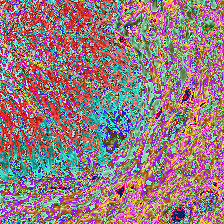

In [63]:
# test
transforms.ToPILImage()(pid_imgs[1][0])

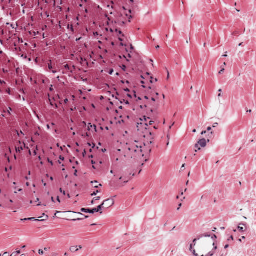

In [64]:
# test
from PIL import Image
Image.open(pids[8][0])

# Models

Number of layers: 13   (initial embeddings + 12 BERT layers)
Number of batches: 1
Number of tokens: 80
Number of hidden units: 768


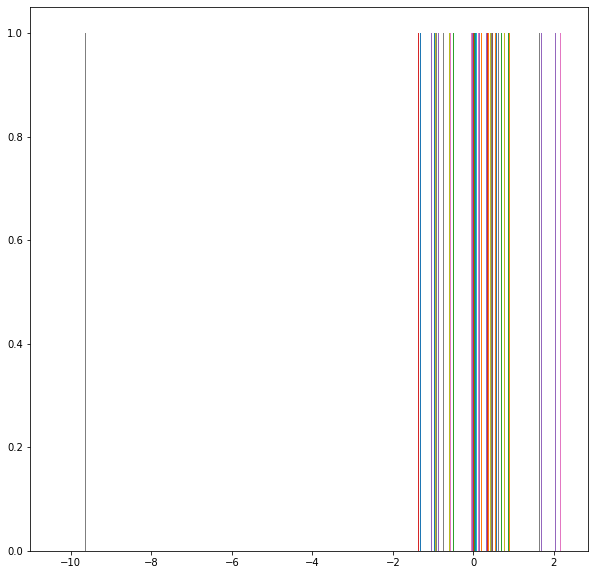

In [65]:
model = BertModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT", output_hidden_states = True)

model.eval()

with torch.no_grad():
    
    segments_ids = [1] * pid_text[0].shape[1]
    segments_tensors = torch.tensor([segments_ids])

    outputs = model(pid_text[0][0].unsqueeze(0), segments_tensors)

    # Evaluating the model will return a different number of objects based on 
    # how it's  configured in the `from_pretrained` call earlier. In this case, 
    # becase we set `output_hidden_states = True`, the third item will be the 
    # hidden states from all layers. See the documentation for more details:
    # https://huggingface.co/transformers/model_doc/bert.html#bertmodel
    hidden_states = outputs[2]

print ("Number of layers:", len(hidden_states), "  (initial embeddings + 12 BERT layers)")
layer_i = 0

print ("Number of batches:", len(hidden_states[layer_i]))
batch_i = 0

print ("Number of tokens:", len(hidden_states[layer_i][batch_i]))
token_i = 0

print ("Number of hidden units:", len(hidden_states[layer_i][batch_i][token_i]))


# For the 5th token in our sentence, select its feature values from layer 5.
token_i = 5
layer_i = 5
vec = hidden_states[layer_i][batch_i][token_i]

# Plot the values as a histogram to show their distribution.
plt.figure(figsize=(10,10))
plt.hist(vec)
plt.show()

In [21]:
# pid_text[0][0]

In [22]:
# print(tokenizer.convert_ids_to_tokens(pid_text[0][0]))

In [23]:
# tokenizer.convert_ids_to_tokens(pid_text[0][0])[5]

In [24]:
# token_embeddings = torch.stack(hidden_states, dim=0)

# token_embeddings.size()

In [25]:
# # Remove dimension 1, the "batches".
# token_embeddings = torch.squeeze(token_embeddings, dim=1)

# token_embeddings.size()

In [26]:
# # Swap dimensions 0 and 1.
# token_embeddings = token_embeddings.permute(1,0,2)

# token_embeddings.size()

In [27]:
# # Stores the token vectors, with shape [22 x 3,072]
# token_vecs_cat = []

# # `token_embeddings` is a [22 x 12 x 768] tensor.

# # For each token in the sentence...
# for token in token_embeddings:
    
#     # `token` is a [12 x 768] tensor

#     # Concatenate the vectors (that is, append them together) from the last 
#     # four layers.
#     # Each layer vector is 768 values, so `cat_vec` is length 3,072.
#     cat_vec = torch.cat((token[-1], token[-2], token[-3], token[-4]), dim=0)
    
#     # Use `cat_vec` to represent `token`.
#     token_vecs_cat.append(cat_vec)

# print ('Shape is: %d x %d' % (len(token_vecs_cat), len(token_vecs_cat[0])))

In [28]:
# # Stores the token vectors, with shape [22 x 768]
# token_vecs_sum = []

# # `token_embeddings` is a [22 x 12 x 768] tensor.

# # For each token in the sentence...
# for token in token_embeddings:

#     # `token` is a [12 x 768] tensor

#     # Sum the vectors from the last four layers.
#     sum_vec = torch.sum(token[-4:], dim=0)
    
#     # Use `sum_vec` to represent `token`.
#     token_vecs_sum.append(sum_vec)

# print ('Shape is: %d x %d' % (len(token_vecs_sum), len(token_vecs_sum[0])))

In [67]:
class BertEncoder(nn.Module):
    def __init__(self, bert_type="emilyalsentzer/Bio_ClinicalBERT", freeze_bert=False,\
                 agg_tokens=True, n_bert_layers=4, agg_method='sum', embedding_dim=768):
        super(BertEncoder, self).__init__()
    
        self.bert_type = bert_type
        self.freeze_bert = freeze_bert
        self.agg_tokens = agg_tokens
        self.n_bert_layers = n_bert_layers
        self.agg_method = agg_method
        self.embedding_dim = embedding_dim        
        
        self.model = BertModel.from_pretrained(self.bert_type, output_hidden_states=True)
#         self.bert_head = nn.Sequential(self.model.embeddings, self.model.encoder.layer[:-4])
#         self.bert_tail = nn.Sequential(self.model.encoder.layer[-4:])
        
        self.tokenizer = AutoTokenizer.from_pretrained(self.bert_type)
        self.idxtoword = {v: k for k, v in self.tokenizer.get_vocab().items()}
        
        for param in self.bert_tail.parameters():
            param.requires_grad = False
        
        if self.freeze_bert is True:
            print("Freezing BERT model")
            for param in self.model.parameters():
                param.requires_grad = False
        
    def aggregate_tokens(self, embeddings, caption_ids):

        batch_size, num_layers, num_words, dim = embeddings.shape
        embeddings = embeddings.permute(0, 2, 1, 3)
        agg_embs_batch = []
        sentences = []

        # loop over batch
        for embs, caption_id in zip(embeddings, caption_ids):

            agg_embs = []
            token_bank = []
            words = []
            word_bank = []

            # loop over sentence
            for word_emb, word_id in zip(embs, caption_id):

                word = self.idxtoword[word_id.item()]

                if word == "[SEP]":
                    new_emb = torch.stack(token_bank)
                    new_emb = new_emb.sum(axis=0)
                    agg_embs.append(new_emb)
                    words.append("".join(word_bank))

                    agg_embs.append(word_emb)
                    words.append(word)
                    break

                if not word.startswith("##"):
                    if len(word_bank) == 0:
                        token_bank.append(word_emb)
                        word_bank.append(word)
                    else:
                        new_emb = torch.stack(token_bank)
                        new_emb = new_emb.sum(axis=0)
                        agg_embs.append(new_emb)
                        words.append("".join(word_bank))

                        token_bank = [word_emb]
                        word_bank = [word]
                else:
                    if word.startswith("##"):
                        token_bank.append(word_emb)
                        word_bank.append(word[2:])

            agg_embs = torch.stack(agg_embs)
            padding_size = num_words - len(agg_embs)
            paddings = torch.zeros(padding_size, num_layers, dim)
            paddings = paddings.to(agg_embs.device)
            words = words + ["[PAD]"] * padding_size

            agg_embs_batch.append(torch.cat([agg_embs, paddings]))
            sentences.append(words)

        agg_embs_batch = torch.stack(agg_embs_batch)
        agg_embs_batch = agg_embs_batch.permute(0, 2, 1, 3)
        return agg_embs_batch, sentences
    
    
    def forward(self, ids, attn_mask, token_type):
        
        outputs = self.bert_head(ids, attn_mask, token_type)
        outputs = self.bert_tail(outputs)
        
        # aggregate intermetidate layers
        if self.n_bert_layers > 1:
            all_embeddings = outputs[2]
            embeddings = torch.stack(
                all_embeddings[-self.n_bert_layers :]
            )  # layers, batch, sent_len, embedding size

            embeddings = embeddings.permute(1, 0, 2, 3)
            
            
            if self.agg_tokens:
                embeddings, sents = self.aggregate_tokens(embeddings, ids)
            else:
                sents = [[self.idxtoword[w.item()] for w in sent] for sent in ids]

            sent_embeddings = embeddings.mean(axis=2)

            if self.agg_method == "sum":
                word_embeddings = embeddings.sum(axis=1)
                sent_embeddings = sent_embeddings.sum(axis=1)
            elif self.agg_method == "mean":
                word_embeddings = embeddings.mean(axis=1)
                sent_embeddings = sent_embeddings.mean(axis=1)
            else:
                print(self.agg_method)
                raise Exception("Aggregation method not implemented")

        # use last layer
        else:
            word_embeddings, sent_embeddings = outputs[0], outputs[1]

        batch_dim, num_words, feat_dim = word_embeddings.shape
        word_embeddings = word_embeddings.view(batch_dim * num_words, feat_dim)
        
        
        word_embeddings = word_embeddings.view(batch_dim, num_words, self.embedding_dim)
        word_embeddings = word_embeddings.permute(0, 2, 1)

        
        return word_embeddings, sent_embeddings, sents

In [68]:
class Resnet50backbone(nn.Module):
    def __init__(self):
        super(Resnet50backbone, self).__init__()
        
        self.resnet_head = nn.Sequential(*list(models.resnet50(pretrained=True).children())[:-1])
        
    def forward(self, x):
        out = self.resnet_head(x)
        return out

# Resnet50backbone()

class ResnetPreTrained(nn.Module):
    def __init__(self, freeze_cnn=False, embedding_dim=768, agg_method='mean'):
        super(ResnetPreTrained, self).__init__()
        
        
        self.freeze_cnn = freeze_cnn
        self.embedding_dim = embedding_dim
        self.agg_method = agg_method
        
        self.resnet = Resnet50backbone()
        self.linear = nn.Linear(in_features=2048, out_features=768, bias=False)
        
        if self.freeze_cnn is True:
            print("Freezing BERT model")
            for param in self.resnet.parameters():
                param.requires_grad = False
    
    def forward(self, x):
        
        out = self.resnet(x)
        out = torch.flatten(out, 1)
        out = self.linear(out)
        
#         if self.agg_method == "sum":
#             out = out.sum(axis=1)
#         elif self.agg_method == "mean":
#             out = out.mean(axis=1)
#         else:
#             print(self.agg_method)
#             raise Exception("Aggregation method not implemented")
        
        
        return out        

img_model = ResnetPreTrained()
img_model.eval()
# model.resnet.requires_grad=False

text_model = BertEncoder()
text_model.eval()

with torch.no_grad():
    print(img.shape)
    text_outputs = text_model(text, attention, token_typ)
    img_outputs = img_model(img)
    print(img_outputs.shape)
    print(text_outputs[0].shape)
    print(text_outputs[1].shape)

torch.Size([64, 3, 224, 224])


TypeError: forward() takes 2 positional arguments but 4 were given

In [19]:
text_outputs[2]

[['[CLS]',
  '2',
  'pieces',
  ';',
  'spermatogenesis',
  'is',
  'reduced',
  '[SEP]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]'],
 ['[CLS]',
  '2',
  'pieces',
  ';',
  'spermatogenesis',
  'is',
  'reduced',
  '[SEP]',
  '[PAD]',
  '[PAD]',
  '[P

In [31]:
%%time
for i, (img, text, attention, token_typ, img_seps, pids) in enumerate(train_loader):
    
    img_seps = [0]+[i.numpy()[0] for i in img_seps]
    img_seps = [[img_seps[i],img_seps[i+1]] for i in range(len(img_seps)-1)]
#     print(img_seps)
    
    img = img.squeeze(0)
    text = text.squeeze(0)
    attention, token_typ = attention.squeeze(0), token_typ.squeeze(0)
    
    with torch.no_grad():
        text_outputs = text_model(text, attention, token_typ)
        img_outputs = img_model(img)
    
    pid_word_embeddings = [text_outputs[0][x:y] for x, y in img_seps]
    pid_sent_embeddings = [text_outputs[1][x:y] for x, y in img_seps]
    

    pid_img_embeddings = [img_outputs[x:y] for x, y in img_seps]

    break

The current process just got forked. Disabling parallelism to avoid deadlocks...
To disable this warning, please explicitly set TOKENIZERS_PARALLELISM=(true | false)
CPU times: user 35.4 s, sys: 7.13 s, total: 42.5 s
Wall time: 13.7 s


In [25]:
text.shape

torch.Size([64, 80])

In [32]:
# text_outputs[0][0:9].shape

In [33]:
t = pid_word_embeddings[0]
t.shape

torch.Size([8, 768, 80])

In [34]:
v = pid_img_embeddings[0]
v.shape

torch.Size([8, 768])

In [35]:
v = v.unsqueeze(1)
v.shape

torch.Size([8, 1, 768])

In [36]:
s = torch.bmm(v, t)
s.shape

torch.Size([8, 1, 80])

In [37]:
a_ij = torch.exp(s)/(torch.sum(torch.exp(s), dim=0))
a_ij.shape

torch.Size([8, 1, 80])

In [38]:
a_ij, v = a_ij.squeeze(1), v.squeeze(1)

In [39]:
a_ij.shape, v.shape

(torch.Size([8, 80]), torch.Size([8, 768]))

In [40]:
c_list = []
for i in range(t.shape[2]):
    c_list.append(torch.sum(torch.stack([a_ij[j][i]*v[j] for j in list(range(v.shape[0]))]), dim=0))

c = torch.stack(c_list).unsqueeze(0)

In [41]:
t.shape, c.shape

(torch.Size([8, 768, 80]), torch.Size([1, 80, 768]))

In [42]:
def return_c_t_vectors(pid_img_embeddings, pid_word_embeddings):
    
    c_vectors = []
    t_vectors = []
    for v, t in zip(pid_img_embeddings, pid_word_embeddings):
        v = v.unsqueeze(1)
        s = torch.bmm(v, t)
        a_ij = torch.exp(s)/(torch.sum(torch.exp(s), dim=0))
        
        a_ij, v = a_ij.squeeze(1), v.squeeze(1)
        
        c_list = []
        for i in range(t.shape[2]):
            c_list.append(torch.sum(torch.stack([a_ij[j][i]*v[j] for j in list(range(v.shape[0]))]), dim=0))

        c = torch.stack(c_list).unsqueeze(0)
        c_vectors.append(c)
        t_vectors.append(t[0])
    
    return torch.stack(c_vectors), torch.stack(t_vectors)

In [65]:
%%time
for i, (img, text, attention, token_typ, img_seps, pids) in enumerate(train_loader):
    
    img_seps = [0]+[i.numpy()[0] for i in img_seps]
    img_seps = [[img_seps[i],img_seps[i+1]] for i in range(len(img_seps)-1)]
    
    img = img.squeeze(0)
    text = text.squeeze(0)
    attention, token_typ = attention.squeeze(0), token_typ.squeeze(0)
    
    with torch.no_grad():
        text_outputs = text_model(text, attention, token_typ)
        img_outputs = img_model(img)
    
    pid_word_embeddings = [text_outputs[0][x:y] for x, y in img_seps]
    pid_sent_embeddings = [text_outputs[1][x:y] for x, y in img_seps]

    pid_img_embeddings = [img_outputs[x:y] for x, y in img_seps]
    
    cap_lens = [len([w for w in sent if not w.startswith("[")]) + 1 for sent in text_outputs[2]]
    cap_lens = [cap_lens[i] for i in np.arange(0, len(cap_lens), 8)]
    print(cap_lens)
    
    c_vectors, t_vectors = return_c_t_vectors(pid_img_embeddings, pid_word_embeddings)
    
    c_vectors = c_vectors.squeeze(1)
    t_vectors = t_vectors.transpose(1,2)

    break

The current process just got forked. Disabling parallelism to avoid deadlocks...
To disable this warning, please explicitly set TOKENIZERS_PARALLELISM=(true | false)
[11, 16, 12, 24, 10, 21, 8, 8]
CPU times: user 43.2 s, sys: 6.61 s, total: 49.9 s
Wall time: 17.1 s


In [66]:
np.arange(0, len(cap_lens), img.shape[0]), img.shape[0], img_outputs.shape

(array([0]), 64, torch.Size([64, 768]))

In [67]:
c_vectors.shape, t_vectors.shape

(torch.Size([8, 80, 768]), torch.Size([8, 80, 768]))

In [68]:
torch.LongTensor(range(8))

tensor([0, 1, 2, 3, 4, 5, 6, 7])

In [71]:
def global_loss(cnn_code, rnn_code, eps=1e-8, temp3=10.0):

    batch_size = cnn_code.shape[0]
    labels = Variable(torch.LongTensor(range(batch_size))).to(cnn_code.device)

    if cnn_code.dim() == 2 :
        cnn_code = cnn_code.unsqueeze(0)
        rnn_code = rnn_code.unsqueeze(0)
        
    cnn_code_norm = torch.norm(cnn_code, 2, dim=2, keepdim=True)
    rnn_code_norm = torch.norm(rnn_code, 2, dim=2, keepdim=True)

    scores0 = torch.bmm(cnn_code, rnn_code.transpose(1,2))
    norm0 = torch.bmm(cnn_code_norm, rnn_code_norm.transpose(1, 2))
    scores0 = scores0 / norm0.clamp(min=eps) * temp3
    
    # --> batch_size x batch_size
    if scores0.shape[0]!=1:
        scores0 = scores0.squeeze()
    else:
        scores0 = scores0.squeeze(0)
    

    scores1 = scores0.transpose(0, 1)
    loss0 = nn.CrossEntropyLoss()(scores0, labels)
    loss1 = nn.CrossEntropyLoss()(scores1, labels)
    return loss0, loss1

In [72]:
global_loss(pid_img_embeddings[0].mean(dim=0).unsqueeze(0), pid_word_embeddings[0][0].mean(dim=1).unsqueeze(0))

(tensor(0.), tensor(0.))

In [73]:
cnn_code = torch.stack([x.mean(dim=0) for x in pid_img_embeddings])
rnn_code = torch.stack([x[0] for x in pid_sent_embeddings])
cnn_code.shape, rnn_code.shape

(torch.Size([8, 768]), torch.Size([8, 768]))

In [74]:
pid_sent_embeddings[2].shape

torch.Size([8, 768])

In [75]:
global_loss(cnn_code, rnn_code)

(tensor(2.0981), tensor(2.1015))

In [76]:
def cosine_similarity(x1, x2, dim=1, eps=1e-8):
    """Returns cosine similarity between x1 and x2, computed along dim."""
    w12 = torch.sum(x1 * x2, dim)
    w1 = torch.norm(x1, 2, dim)
    w2 = torch.norm(x2, 2, dim)
    return (w12 / (w1 * w2).clamp(min=eps)).squeeze()

def attention_fn(query, context, temp1):
    """
    query: batch x ndf x queryL
    context: batch x ndf x ih x iw (sourceL=ihxiw)
    mask: batch_size x sourceL
    """
    batch_size, queryL = query.size(0), query.size(2)
    ih, iw = context.size(2), context.size(3)
    sourceL = ih * iw

    # --> batch x sourceL x ndf
    context = context.view(batch_size, -1, sourceL)
    contextT = torch.transpose(context, 1, 2).contiguous()

    # Get attention
    # (batch x sourceL x ndf)(batch x ndf x queryL)
    # -->batch x sourceL x queryL
    attn = torch.bmm(contextT, query)
    # --> batch*sourceL x queryL
    attn = attn.view(batch_size * sourceL, queryL)
    attn = nn.Softmax(dim=-1)(attn)

    # --> batch x sourceL x queryL
    attn = attn.view(batch_size, sourceL, queryL)
    # --> batch*queryL x sourceL
    attn = torch.transpose(attn, 1, 2).contiguous()
    attn = attn.view(batch_size * queryL, sourceL)

    attn = attn * temp1
    attn = nn.Softmax(dim=-1)(attn)
    attn = attn.view(batch_size, queryL, sourceL)
    # --> batch x sourceL x queryL
    attnT = torch.transpose(attn, 1, 2).contiguous()

    # (batch x ndf x sourceL)(batch x sourceL x queryL)
    # --> batch x ndf x queryL
    weightedContext = torch.bmm(context, attnT)

    return weightedContext, attn.view(batch_size, -1, ih, iw)

def local_loss(
    img_features, words_emb, cap_lens, temp1=4.0, temp2=5.0, temp3=10.0, agg="sum"
):

    batch_size = img_features.shape[0]

    att_maps = []
    similarities = []
    # cap_lens = cap_lens.data.tolist()
    for i in range(words_emb.shape[0]):

        # Get the i-th text description
        words_num = cap_lens[i]  # 25
        # TODO: remove [SEP]
        # word = words_emb[i, :, 1:words_num+1].unsqueeze(0).contiguous()    # [1, 768, 25]
        word = words_emb[i, :, :words_num].unsqueeze(0).contiguous()  # [1, 768, 25]
        word = word.repeat(batch_size, 1, 1)  # [48, 768, 25]
        context = img_features  # [48, 768, 19, 19]

        weiContext, attn = attention_fn(
            word, context, temp1
        )  # [48, 768, 25], [48, 25, 19, 19]

        att_maps.append(
            attn[i].unsqueeze(0).contiguous()
        )  # add attention for curr index  [25, 19, 19]
        word = word.transpose(1, 2).contiguous()  # [48, 25, 768]
        weiContext = weiContext.transpose(1, 2).contiguous()  # [48, 25, 768]

        word = word.view(batch_size * words_num, -1)  # [1200, 768]
        weiContext = weiContext.view(batch_size * words_num, -1)  # [1200, 768]

        row_sim = cosine_similarity(word, weiContext)
        row_sim = row_sim.view(batch_size, words_num)  # [48, 25]

        row_sim.mul_(temp2).exp_()
        if agg == "sum":
            row_sim = row_sim.sum(dim=1, keepdim=True)  # [48, 1]
        else:
            row_sim = row_sim.mean(dim=1, keepdim=True)  # [48, 1]
        row_sim = torch.log(row_sim)

        similarities.append(row_sim)

    similarities = torch.cat(similarities, 1)  #
    similarities = similarities * temp3
    similarities1 = similarities.transpose(0, 1)  # [48, 48]

    labels = Variable(torch.LongTensor(range(batch_size))).to(similarities.device)

    loss0 = nn.CrossEntropyLoss()(similarities, labels)  # labels: arange(batch_size)
    loss1 = nn.CrossEntropyLoss()(similarities1, labels)
    return loss0, loss1, att_maps

In [79]:
text_outputs[0].shape

torch.Size([64, 768, 80])

In [80]:
img_features=img_outputs.unsqueeze(2).unsqueeze(2)

In [81]:
img_features = [x.unsqueeze(2).unsqueeze(2) for x in pid_img_embeddings]
img_features = [x.permute(2,1,0,3) for x in img_features]
img_features = torch.stack(img_features, dim=0).squeeze(1)

img_features.shape

torch.Size([8, 768, 8, 1])

In [82]:
text_outputs[0].shape

torch.Size([64, 768, 80])

In [83]:
words_embs = [x[0] for x in pid_word_embeddings]
words_embs = torch.stack(words_embs)
words_embs.shape

torch.Size([8, 768, 80])

In [84]:
loss0, loss1, att_maps=local_loss(img_features, words_embs, cap_lens)

In [85]:
loss0.backward()

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [95]:
cap_lens

[11, 16, 12, 24, 10, 21, 8, 8]

In [88]:
loss0, loss1

(tensor(6.9495), tensor(2.2907))

In [91]:
att_maps[0].shape

torch.Size([1, 11, 8, 1])

In [94]:
att_maps[3].shape

torch.Size([1, 24, 8, 1])

In [94]:
text_model

BertEncoder(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)

In [108]:
freeze_modules = [text_model.model.embeddings, *text_model.model.encoder.layer[:-4]]
non_freeze_modules = [*text_model.model.encoder.layer[:-4]]

In [109]:
param_list = []
for module in freeze_modules:
    for param in module.parameters():
        param.requires_grad = False
        param_list.append(param)
        
for module in non_freeze_modules:
    for param in module.parameters():
        param_list.append(param)

In [106]:
[params for params in text_model.model.embeddings.parameters()]

[Parameter containing:
 tensor([[-0.0333, -0.0794, -0.0196,  ..., -0.0365, -0.0359,  0.0013],
         [ 0.0125, -0.0182, -0.0349,  ..., -0.0387, -0.0596, -0.0106],
         [-0.0384, -0.0131,  0.0037,  ..., -0.0394, -0.0423, -0.0357],
         ...,
         [-0.0045, -0.0044, -0.0520,  ..., -0.0384, -0.0762, -0.0117],
         [-0.0235,  0.0125, -0.0237,  ..., -0.0818,  0.0034, -0.0393],
         [ 0.0488, -0.0234, -0.0319,  ..., -0.0522, -0.0444, -0.0116]],
        requires_grad=True),
 Parameter containing:
 tensor([[ 0.0287,  0.0030, -0.0199,  ...,  0.0096,  0.0224,  0.0312],
         [-0.0332,  0.0009,  0.0085,  ...,  0.0180,  0.0147,  0.0012],
         [-0.0041, -0.0087,  0.0084,  ...,  0.0063,  0.0046, -0.0088],
         ...,
         [ 0.0318, -0.0015, -0.0311,  ..., -0.0209, -0.0029, -0.0181],
         [ 0.0075, -0.0254, -0.0435,  ..., -0.0024, -0.0260, -0.0173],
         [-0.0081, -0.0148, -0.0246,  ...,  0.0275, -0.0423, -0.0056]],
        requires_grad=True),
 Parameter con